In [5]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi
import cv2

from skimage import data
from skimage.color import rgb2hsv, rgb2gray
from utils import load_input_image
from segmentation import Segmentation

In [6]:
imgs = {i: load_input_image(i,folder="train2") for i in range(12)}

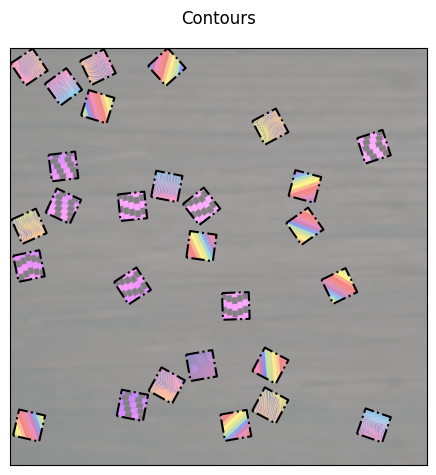

In [7]:
n=7

img = imgs[7]
seg = Segmentation(img)
seg.find_pieces()
seg.plot_contours()

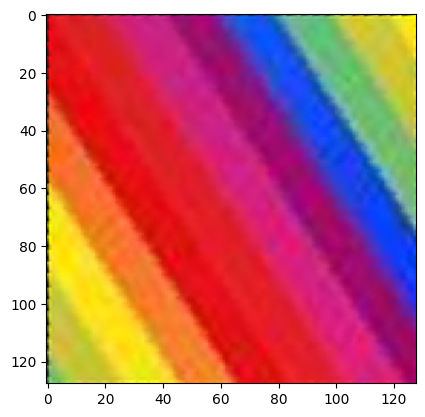

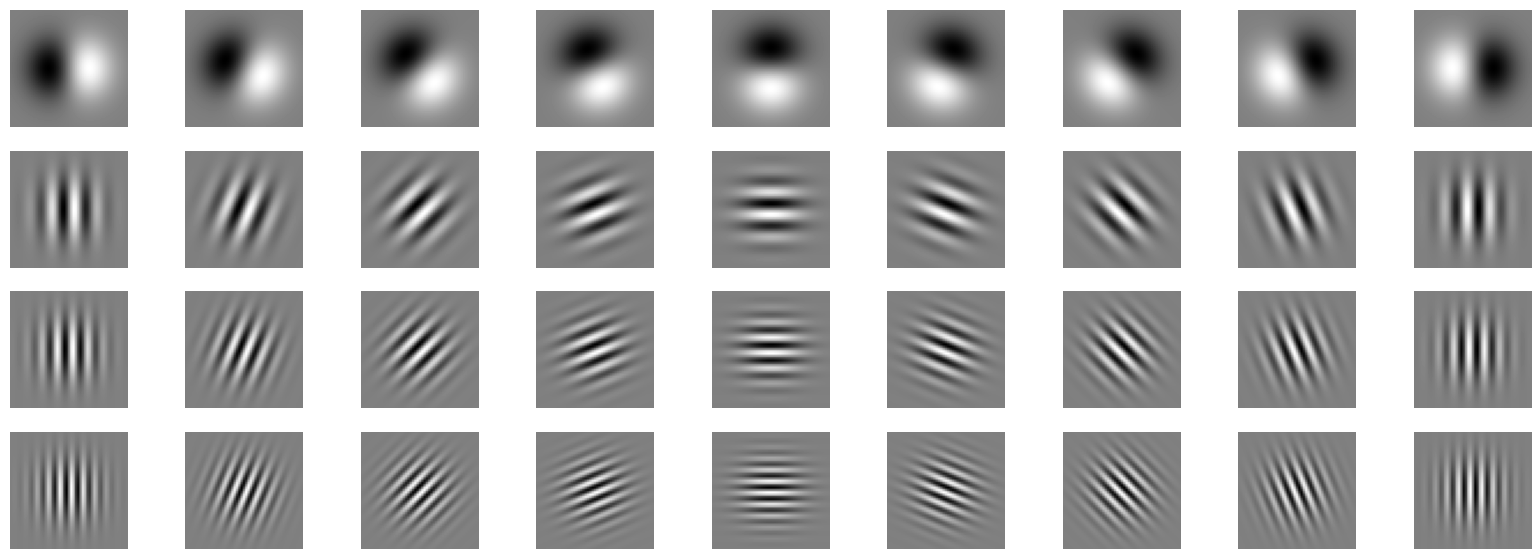

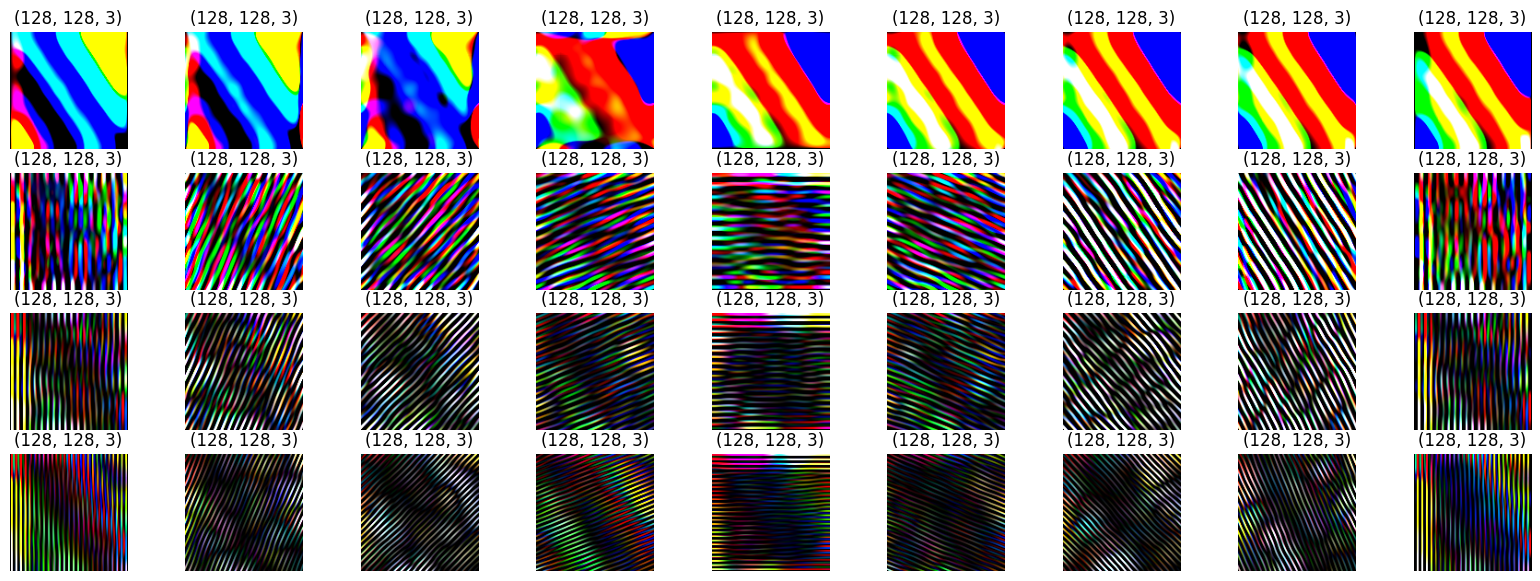

In [9]:
piece = seg.pieces[1]
plt.imshow(piece)
ksize = 51
gamma = 1
phi = np.pi/2
sigma = 9
nth = 9
freqs = [ 0.005, 0.1, 0.15, 0.2]
thetas = np.linspace(0, np.pi, nth)
nf = len(freqs)
fig, axs = plt.subplots(nf,nth, figsize=(20,7))
fig1, axs1 = plt.subplots(nf,nth, figsize=(20,7))
for i,f in enumerate(freqs):
        for j, theta in enumerate(thetas):

            lamda = 1 / f

            kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi)
            f_img = cv2.filter2D(piece, cv2.CV_8UC3, kernel)
            #img_hsv = rgb2hsv(f_img)

            axs[i,j].imshow(kernel)
            axs[i,j].axis('off')

            axs1[i,j].imshow(np.abs(f_img))
            axs1[i,j].set_title(round(np.mean(np.abs(f_img))))
            axs1[i,j].axis('off')
plt.show()

In [12]:
def get_features(img):
    img_hsv = rgb2hsv(img)

    means = np.mean(img, axis=(0,1))
    std   = np.std(img, axis=(0,1))
    means_hsv = np.mean(img_hsv, axis=(0,1))
    std_hsv   = np.std(img_hsv, axis=(0,1))

    transform = np.fft.fft2(rgb2gray(img))
    fourier = np.mean(np.abs(transform[:20, :20]))
    means_gabor = []
    std_gabor = []

    ksize = 51
    gamma = 1
    phi = np.pi/2
    sigma = 9
    nth = 9
    freqs = [ 0.005, 0.1, 0.15, 0.2]
    thetas = np.linspace(0, np.pi, nth)

    for f in freqs:
        for theta in thetas:

            lamda = 1 / f

            kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi)
            f_img = cv2.filter2D(piece, cv2.CV_8UC3, kernel)
            img_hsv = rgb2hsv(f_img)

            means_f = np.mean(np.abs(f_img), axis=(0,1))
            std_f   = np.std(np.abs(f_img), axis=(0,1))
            means_hsv = np.mean(np.abs(img_hsv), axis=(0,1))
            std_hsv   = np.std(np.abs(img_hsv), axis=(0,1))
            means_gabor.extend(list(means_f))
            means_gabor.extend(list(means_hsv))
            std_gabor.extend(list(std_f))
            std_gabor.extend(list(std_hsv))

    return np.hstack([means, std, means_hsv, std_hsv, means_gabor, std_gabor, fourier])

In [13]:
def get_features(img):
    img_hsv = rgb2hsv(img)

    means = np.mean(img, axis=(0,1))
    std   = np.std(img, axis=(0,1))
    means_hsv = np.mean(img_hsv, axis=(0,1))
    std_hsv   = np.std(img_hsv, axis=(0,1))

    transform = np.fft.fft2(rgb2gray(img))
    fourier = np.mean(np.abs(transform[:20, :20]))
    means_gabor = []
    std_gabor = []

    ksize = 31
    gamma = 1
    phi = np.pi/2
    sigma = 7
    nth = 9
    freqs = [ 0.005, 0.1, 0.15, 0.2]
    thetas = np.linspace(0, np.pi, nth)

    for f in freqs:
        for theta in thetas:

            lamda = 1 / f

            kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi)
            f_img = cv2.filter2D(piece, cv2.CV_8UC3, kernel)
            img_hsv = rgb2hsv(f_img)

            means_f = np.mean(np.abs(f_img), axis=(0,1))
            std_f   = np.std(np.abs(f_img), axis=(0,1))
            means_hsv = np.mean(np.abs(img_hsv), axis=(0,1))
            std_hsv   = np.std(np.abs(img_hsv), axis=(0,1))
            means_gabor.extend(list(means_f))
            means_gabor.extend(list(means_hsv))
            std_gabor.extend(list(std_f))
            std_gabor.extend(list(std_hsv))

    return np.hstack([means, std, means_hsv, std_hsv, means_gabor, std_gabor, fourier])

In [14]:
features = np.array([get_features(seg.pieces[i]) for i in range(len(seg.pieces))])
features = (features - np.mean(features, axis=0)) / np.maximum(1e-5, np.std(features, axis=0))
features.shape

(20, 445)

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(features)
print(pca.explained_variance_ratio_)
features_PCA = pca.transform(features)
features_PCA.shape


[0.71812585 0.11980724 0.08359467]


(20, 3)

In [16]:
indexes = np.zeros_like(features_PCA[:,0], dtype=bool)

index_piece = [1, 2,5,6,9,11,14,15,18]
indexes[index_piece] = True
features_PCA_p1 = features_PCA[indexes]
index_out = [0]
features_PCA_po = features_PCA[index_out]
indexes[index_out] = True
features_PCA_p0 = features_PCA[~indexes]

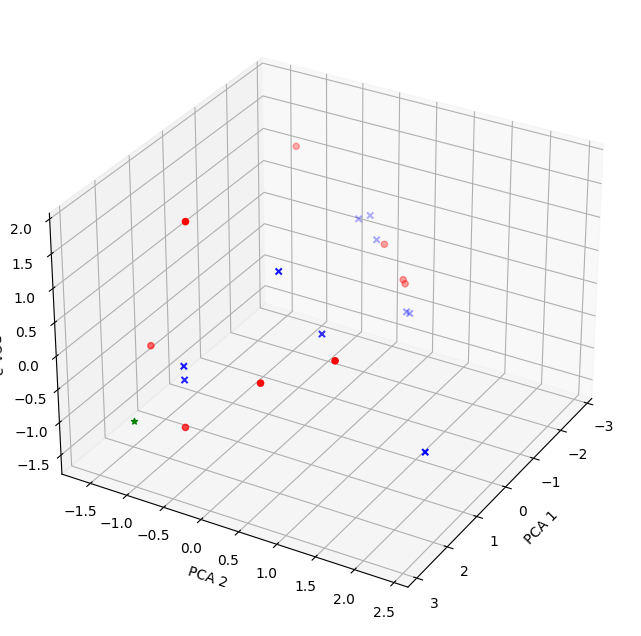

In [17]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Plotting the transformed features
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Extract the transformed features
x = features_PCA_p0[:, 0]
y = features_PCA_p0[:, 1]
z = features_PCA_p0[:, 2]

# Create a 3D scatter plot of the transformed features
ax.scatter(x, y, z, c='b', marker='x')

x = features_PCA_p1[:, 0]
y = features_PCA_p1[:, 1]
z = features_PCA_p1[:, 2]

# Create a 3D scatter plot of the transformed features
ax.scatter(x, y, z, c='r', marker='o')

x = features_PCA_po[:,0]
y = features_PCA_po[:,1]
z = features_PCA_po[:,2]

# Create a 3D scatter plot of the transformed features
ax.scatter(x, y, z, c='g', marker='*')

# Set the axis labels
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')

# Change the viewing angle
ax.view_init(elev=30, azim=30)

# Show the plot
plt.show()


In [18]:
from matplotlib import cbook
from matplotlib import cm
from matplotlib.colors import LightSource
import matplotlib.pyplot as plt
import numpy as np

z = np.abs(transform)

nrows, ncols = z.shape
x = np.linspace(0, transform.shape[0], ncols)
y = np.linspace(0, transform.shape[0], nrows)
x, y = np.meshgrid(x, y)

region = np.s_[5:50, 5:50]
x, y, z = x[region], y[region], z[region]

# Set up plot
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))

ls = LightSource(270, 45)
# To use a custom hillshading mode, override the built-in shading and pass
# in the rgb colors of the shaded surface calculated from "shade".
rgb = ls.shade(z, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=rgb,
                       linewidth=0, antialiased=False, shade=False)

plt.show()

NameError: name 'transform' is not defined

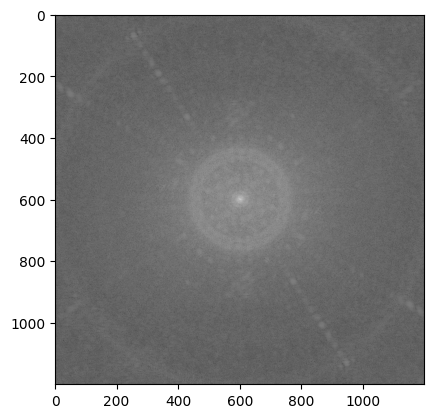

In [ ]:
img= imgs[4]

transform = np.fft.fft2(rgb2gray(img))
fshift = np.fft.fftshift(transform)
plt.imshow(np.log(np.abs(fshift[400:-400, 400:-400])))